
# Logistic Regression with Python

we will be working with the ```Titanic Data Set```.

It includes passenger information like name, age, gender, socio-economic class, etc. 

We want to build a model to predict a classification survival or deceased based on a specific set of features.

We will implement Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set but you may need to do some additional cleaning .

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rc("font", size=18)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [3]:
data = pd.read_csv('titanic.csv')

- survival - Survival (0 = No; 1 = Yes)
- class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- name - Name
- sex - Sex
- age - Age
- sibsp - Number of Siblings/Spouses Aboard
- parch - Number of Parents/Children Aboard
- ticket - Ticket Number
- fare - Passenger Fare
- cabin - Cabin
- embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data.shape

(891, 12)

# Exploratory Data Analysis and Feature Engineering

##### Show the distribution of the classes

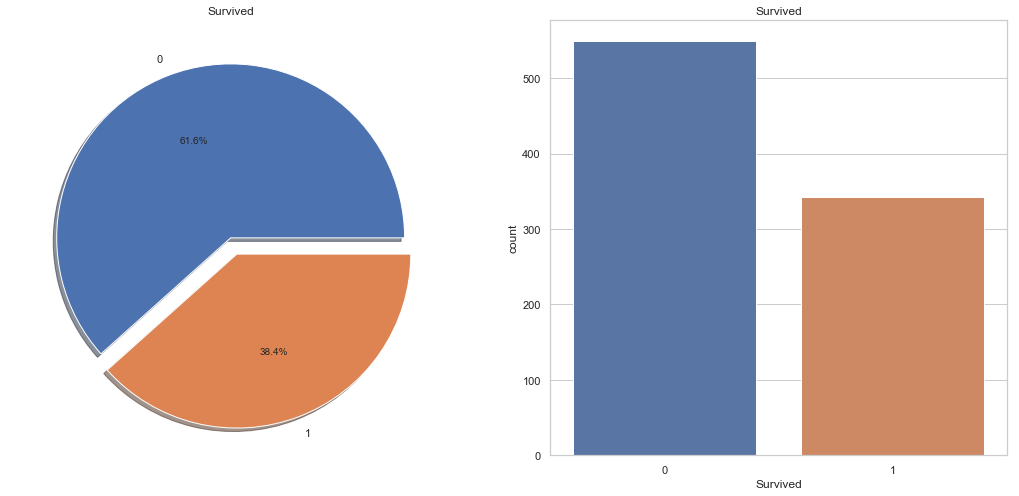

In [6]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=data,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

Not many passengers survived the accident.

## Missing Data

Look for missing data and then you will perform imputation where you think it makes sense.


In [7]:
# check missing values in train data
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can use seaborn to create a simple heatmap to see where we are missing data!

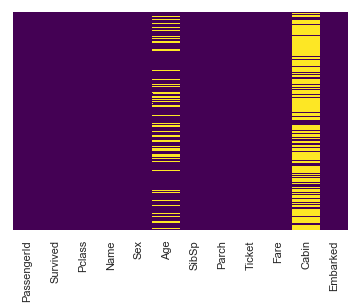

In [8]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
# percent of missing "Age" 
print('Percent of missing data in column "Age" is %.2f%%' %((data['Age'].isnull().sum()/data.shape[0])*100))

Percent of missing data in column "Age" is 19.87%


- Around 20 percent of the Age data is missing. This percentage is not so high, we can fill the missing age through imputation.

- Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this coulumn later.


##### Analyse the Age column, in general and separately for each class

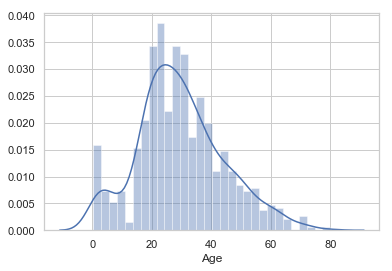

In [10]:

sns.distplot(data['Age'].dropna(), bins=30);

Since "Age" is (right) skewed, using the mean might give us biased results by filling in ages that are older than desired. To deal with this, we'll use the median to impute the missing values.

Text(0.5, 1.0, 'Survived')

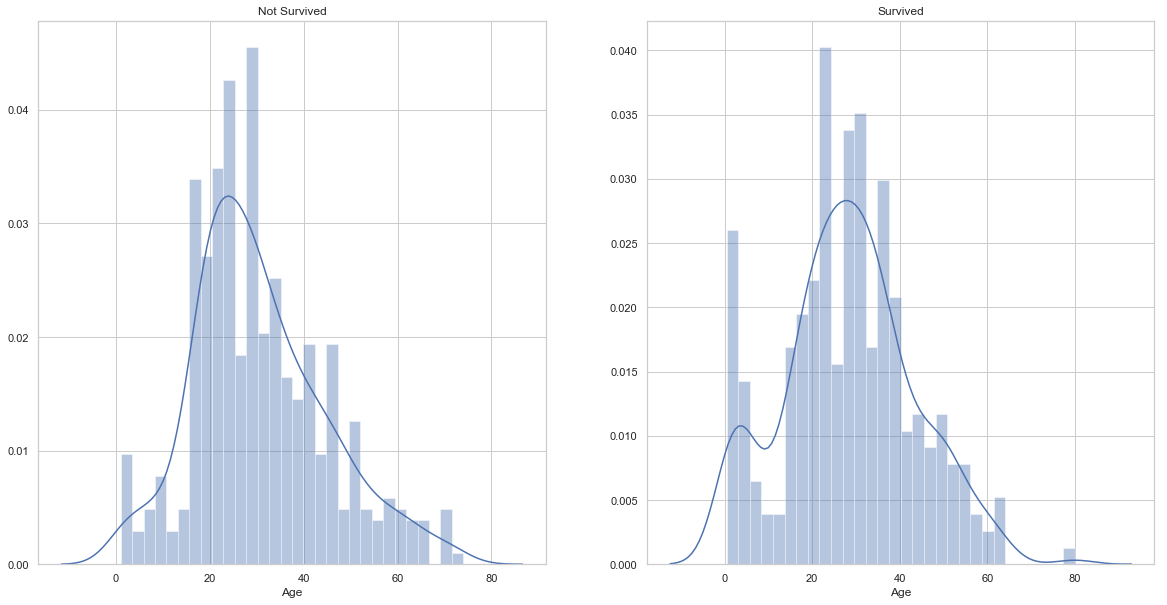

In [11]:
f,ax=plt.subplots(1,2,figsize=(20,10))

sns.distplot(data[data['Survived']==0]['Age'].dropna(), bins=30, ax=ax[0]);
ax[0].set_title('Not Survived')

sns.distplot(data[data['Survived']==1]['Age'].dropna(), bins=30, ax=ax[1]);
ax[1].set_title('Survived')

Children less than 5-10 years do have a high chance of survival. Passengers between age group 15 to 35 died a lot.

#### Gender

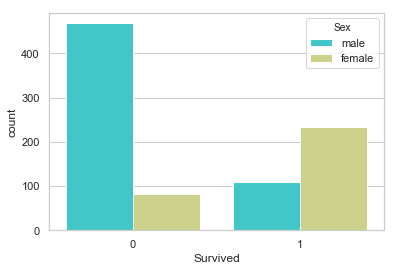

In [12]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=data, palette='rainbow')


The number of men on the ship is lot more than the number of women. Still the number of women saved is almost twice the number of males saved. 

In [50]:
table = pd.crosstab(data.Pclass, data.Survived)
table

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [63]:
table.sum(1)

Pclass
1    216
2    184
3    491
dtype: int64

In [56]:
table.div(table.sum(1).astype(float), axis=0)

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


Text(0, 0.5, 'Percentage of survived')

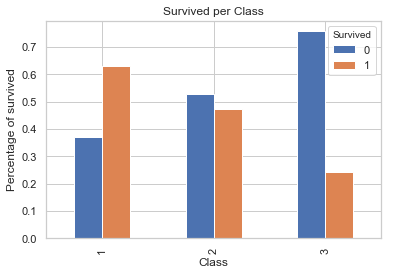

In [13]:
table = pd.crosstab(data.Pclass, data.Survived)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Survived per Class')
plt.xlabel('Class')
plt.ylabel('Percentage of survived')

We can clearly observe that passenger in Class 1 had a much higher probability to survive!

##### SibSip: This feature represents whether a person is alone or with his family members.

Text(0, 0.5, 'Percentage of survived')

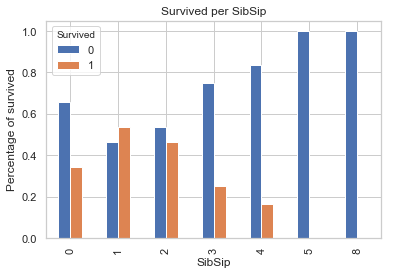

In [14]:
table = pd.crosstab(data.SibSp, data.Survived)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Survived per SibSip')
plt.xlabel('SibSip')
plt.ylabel('Percentage of survived')

If a passenger is alone or with only one parent has good chances to Survive. roughly decreases if the number of siblings increase. Maybe if I have a family on board, I will try to save them instead of saving myself first. Notice that the survival for families with more than 5 members is 0%. 

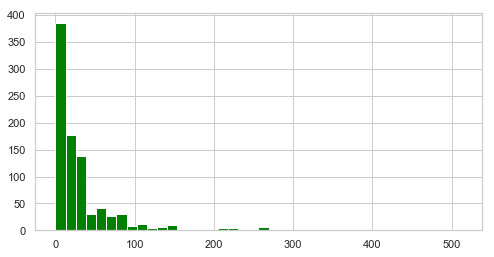

In [15]:
data['Fare'].hist(color='green',bins=40,figsize=(8,4))

Distribution of ages per class and for survived and not survived

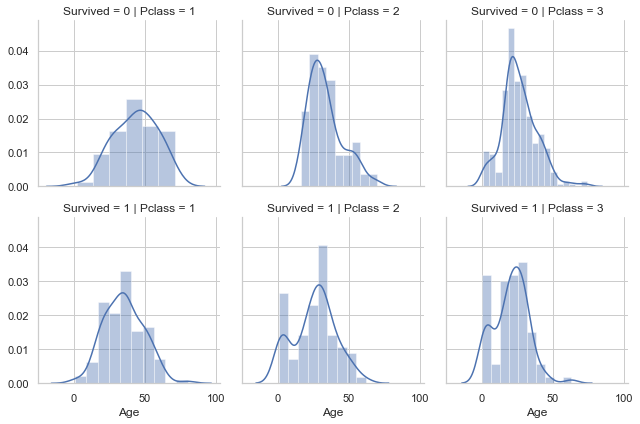

In [16]:
g = sns.FacetGrid(data, row='Survived', col='Pclass')
g.map(sns.distplot, "Age")
plt.show()

## Data preprocessing

**Feature Engineering plays an important role in regards to the performance of Logistic**

We want to fill in missing age data instead of just dropping the missing age data rows. 

In case of missing value we will assign the median value of the passengers in the same class.


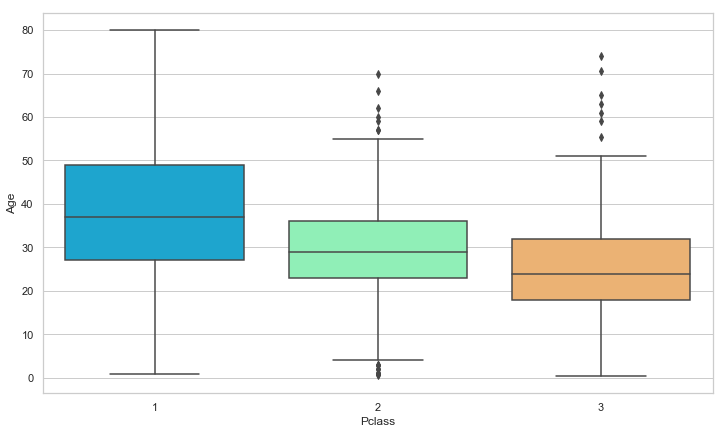

In [17]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=data,palette='rainbow')

Compute the median age per class

In [18]:
data.groupby(['Pclass'])['Age'].median().reset_index()

,Pclass,Age
0,1,37.0
1,2,29.0
2,3,24.0


We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [19]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Now apply that function!

In [20]:
data['Age'] = data[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


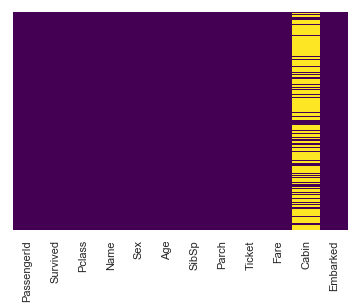

In [21]:
print(# check missing values in train data
data.isnull().sum())
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Drop the Cabin column 

In [22]:
data.drop('Cabin',axis=1,inplace=True)

In [23]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


There are only 2 missing values for "Embarked", so we can just impute with the port where most people boarded.

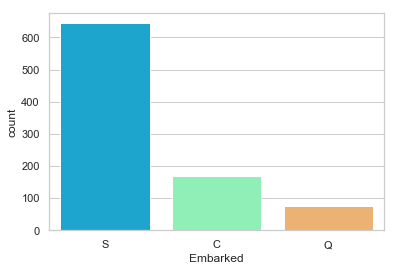

In [24]:
sns.countplot(x='Embarked',data=data,palette='rainbow')
plt.show()

The most passengers boarded in Southhampton, so we'll impute those 2 NaN's with "S".

In [25]:
data["Embarked"].fillna("S", inplace=True)

## Converting Categorical Features 

Convert categorical variable into dummy/indicator variables otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


In [27]:

data = pd.get_dummies(data, columns=['Sex','Embarked','Pclass'],drop_first=True)
data.head(3)


,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,0,1,0,1


##### Drop those feature that in your opinion are not relevant for the model

In [28]:
data.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)

In [29]:
data.head()

,Survived,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,1,0,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,0,1,0,1
3,1,35.0,1,0,53.1000,0,0,1,0,0
4,0,35.0,0,0,8.0500,1,0,1,0,1


Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set. Use 30% of the data as test set and set random_state=101

## Train Test Split

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Survived',axis=1), 
                                                    data['Survived'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/Users/matteo.manca/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [34]:
predictions = logmodel.predict(X_test)

## Model Evaluation

We can check **precision, recall, f1-score** using classification report!

In [35]:
from sklearn.metrics import classification_report


In [36]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.78      0.90      0.83       154
           1       0.82      0.65      0.73       114

   micro avg       0.79      0.79      0.79       268
   macro avg       0.80      0.77      0.78       268
weighted avg       0.80      0.79      0.79       268



You might want to explore other feature engineering like:

* Create age groups
* Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
* ...


##### Age groups

In [37]:
bins = [0, 12, 17, 60, np.inf]
labels = ['child', 'teenager', 'adult', 'elder']
age_groups = pd.cut(data.Age, bins, labels=labels)
data['age_group'] = age_groups
data.head()

,Survived,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,age_group
0,0,22.0,1,0,7.2500,1,0,1,0,1,adult
1,1,38.0,1,0,71.2833,0,0,0,0,0,adult
2,1,26.0,0,0,7.9250,0,0,1,0,1,adult
3,1,35.0,1,0,53.1000,0,0,1,0,0,adult
4,0,35.0,0,0,8.0500,1,0,1,0,1,adult


In [46]:
data = pd.read_csv('titanic.csv')
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
data.head(3)



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss


In [49]:
data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [48]:
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')